<a href="https://colab.research.google.com/github/realjustfree/ThinkLinearAlgebra/blob/main/chapters/eigenvector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# The Power of Linear Algebra

One of the challenges of learning Linear Algebra is where to start.
Most textbooks start with vector arithmetic, which make senses if you are working with paper and pencil, but they take a long time to get to something useful.

With a computational approach, we have the option to proceed top-down -- that is, we can start with libraries that implement the core algorithms of linear algebra, and wait until later to see how they work.
With this approach we can can get to the good stuff faster.

To demonstrate, this chapter introduces vectors, matrices, and matrix-vector multiplication.
We'll use these tools to simulate a random walk in a network, and we'll implement the PageRank algorithm Google used to revolutionize web search.
Along the way, we'll learn about eigenvectors, one of the most powerful ideas in linear algebra.

That's a lot for just one chapter, so we'll move quickly.
If you don't feel like you understand all of it deeply, don't worry -- we'll come back to these topics in future chapters.
But I hope you'll find it useful to get the big picture before we fill in the details.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/chapters/eigenvector.ipynb).

In [5]:
# temporary hack to make autoreload work on Colab
import importlib, sys
sys.modules["imp"] = importlib

%load_ext autoreload
%autoreload 2

In [6]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [7]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp

from utils import decorate

In [8]:
from utils import set_precision

set_precision(3)

## A Day at the Museum

Suppose you are meeting a friend at the Isabella Stewart Gardner Museum in Boston.
You have not agreed on a meeting place -- and let's assume your cell phone is dead.
If you are familiar with the layout of the museum, you might be able to make an intelligent guess about where to look for your friend.

As a rough model of the situation, suppose your friend has been at the museum for some time, wandering from room to room at random.
By simulating this random walk, we can compute their probability of being in each room.

As a small example, we'll create a graph that represents just a few of the rooms and the connections between them (based on the actual layout of the Gardner Museum).

In [9]:
G = nx.Graph()
edges = [
    ("Lobby", "Living Room"),
    ("Lobby", "Shop"),
    ("Lobby", "Main Stair"),
    ("Living Room", "Main Stair"),
    ("Main Stair", "Café"),
    ("Café", "Garden"),
]
G.add_edges_from(edges)

Here's what the graph looks like.

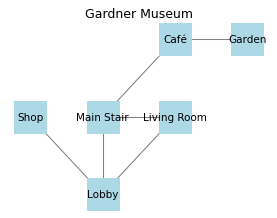

In [10]:
# Approximate positions (manually aligned to floor plan layout)
positions = {
    "Lobby": (0, 0),
    "Main Stair": (0, 1),
    "Shop": (-1, 1),
    "Garden": (2, 2),
    "Living Room": (1, 1),
    "Café": (1, 2),
}

plt.figure(figsize=(3.5, 2.5))
nx.draw(
    G, positions,
    with_labels=True,
    node_color='lightblue',
    node_size=1000,
    node_shape='s',
    font_size=10,
    edge_color='gray'
)
plt.title("Gardner Museum")
plt.axis('off');

The following function takes this graph and simulates a random walk through the museum.
It uses a `Counter` to keep track of the number of times each room is visited.
Then it divides through by the number of iterations, so the values in the `Counter` add up to  one.

In [12]:
import random
from collections import Counter

def random_walk(G, start, iters=1000):
    counter = Counter()
    node = start

    for _ in range(iters):
        node = random.choice(list(G[node]))
        counter[node] += 1

    for key in counter:
        counter[key] /= iters

    return counter

Here are the results.

In [13]:
random_walk(G, 'Lobby')

Counter({'Living Room': 0.176,
         'Lobby': 0.253,
         'Main Stair': 0.259,
         'Café': 0.156,
         'Shop': 0.088,
         'Garden': 0.068})

These values estimate the long-run probabilities of finding a random walker in each room.

In reality, your friend doesn't wander completely at random, and they have not been in the museum forever.
Even so, it is probably true that you are more likely to find them in the Lobby or Main Stair, and less likely to find them in the Shop or Garden.

So far, there is not much linear algebra in this linear algebra book.
Let's see what we can do about that.

## The Adjacency Matrix

As a first step toward linear algebra, we'll use the `to_numpy_array` method to compute an array that represents the edges in the graph.

In [ ]:
A = nx.to_numpy_array(G).astype(int)
A

array([[0, 1, 1, 1, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 0]])

This result is called an **adjacency matrix**.
Each element is either `1` to indicate that there is an edge between two nodes or `0` to indicate that there is not.
Each row corresponds to one node, in the order they appear in the graph.
We'll use the following function to label the rows and columns with the names of the rooms.

In [ ]:
def show_matrix(A, G):
     return pd.DataFrame(A, index=G.nodes, columns=G.nodes)

In [ ]:
show_matrix(A, G)

,Lobby,Living Room,Shop,Main Stair,Café,Garden
Lobby,0,1,1,1,0,0
Living Room,1,0,0,1,0,0
Shop,1,0,0,0,0,0
Main Stair,1,1,0,0,1,0
Café,0,0,0,1,0,1
Garden,0,0,0,0,1,0


So the first row indicates that there are edges from the Lobby to the Living Room, Shop, and Main Stair, but not to the other rooms (and not to itself).

You might notice that the object we created is a NumPy *array*, but it is called an adjacency *matrix*, and you might wonder what the difference is.
This is a common source of confusion, made worse because people often use the terms interchangeably.

An array is a general-purpose way to store multidimensional data.
In this example it's two-dimensional, but arrays can have any number of dimensions.
An array can be used to represent a matrix, but it can also represent other things.

A matrix a mathematical entity defined in linear algebra.
If you say that an object is a matrix, that implies that it follows matrix rules.
For example, when we multiply matrixes, we'll perform matrix multiplication, which is different in important ways from multiplication of plain old numbers.

The difference between a matrix and an array is similar to the difference between a number and a numeral.
For example, the number two can be represented by the Hindu-Arabic numeral `2`.
But it can also be represented by the Roman numeral `Ⅱ` or by the Suzhou numeral `〢`.
So a number is a mathematical entity that can be represented by different numerals, and a matrix is an entity that can be represented by different data structures.

We can use the adjacency matrix to compute a **transition matrix**, which represents the probability that a random walker moves from each room to the others.

We use the following function, computing the sum of each column and dividing through so that each column adds up to `1`.

In [ ]:
def make_transition_matrix(A):
    return A / A.sum(axis=0, keepdims=True)

Here's the transition matrix for the museum graph.

In [ ]:
M = make_transition_matrix(A)
show_matrix(M, G)

,Lobby,Living Room,Shop,Main Stair,Café,Garden
Lobby,0.000,0.500,1.000,0.333,0.000,0.000
Living Room,0.333,0.000,0.000,0.333,0.000,0.000
Shop,0.333,0.000,0.000,0.000,0.000,0.000
Main Stair,0.333,0.500,0.000,0.000,0.500,0.000
Café,0.000,0.000,0.000,0.333,0.000,1.000
Garden,0.000,0.000,0.000,0.000,0.500,0.000


To understand what this means, let's consider the first row.

In [ ]:
row0 = M[0]
row0

array([0.   , 0.5  , 1.   , 0.333, 0.   , 0.   ])

Each row is a one-dimensional array that we can think of as a vector.
Like a matrix, a vector is a mathematical entity that can be represented many ways -- but in this chapter we'll use arrays.
We'll use the following function to display vectors with labels.

In [ ]:
def show_vector(v, G, index):
    return pd.DataFrame([v], index=[index], columns=G.nodes)

Here's the first row again.

In [ ]:
show_vector(row0, G, 'Lobby')

,Lobby,Living Room,Shop,Main Stair,Café,Garden
Lobby,0.000,0.500,1.000,0.333,0.000,0.000


We can interpret the elements of this vector as transition probabilities from other rooms to the Lobby.
For example, the element corresponding to the Living Room is 0.5, which means that if someone is in the Living Room and they follow a random edge, the probability they end up in the Lobby is 0.5.
If they leave the Shop, the probability is 1, and if they leave the Main Stair, the probability is 0.333.

## Dot Product

Now suppose there are 100 people in every room.
We can create an array that represents this hypothetical starting condition.

In [ ]:
N = len(G)
x0 = np.full(N, 100)
show_vector(x0, G, 'count')

,Lobby,Living Room,Shop,Main Stair,Café,Garden
count,100,100,100,100,100,100


And now suppose that everyone leaves the room they are in, choosing one of the exits at random.
To find out how many of them end up in the Lobby, we can multiply `row0` by `x`.

In [ ]:
product = row0 * x0
show_vector(product, G, 'Lobby')

,Lobby,Living Room,Shop,Main Stair,Café,Garden
Lobby,0.000,50.000,100.000,33.333,0.000,0.000


When we use the `*` operator to multiply two arrays, the multiplication happens **elementwise** -- that is, each element from one vector is multiplied by the corresponding element of the other.

The result indicates that 50 people would move from the Living Room to the Lobby, 100 from the Shop, and 33.33 from the Main Stair.
The total number of people who would end up in the library is the sum of these products.

In [ ]:
product.sum()

183.333

The sum of elementwise products is an "inner product", more often called a **dot product** because the operator used to denote it is a dot.
For example, the dot product of vectors $\mathbf{u}$ and $\mathbf{v}$ is denoted $\mathbf{u} \cdot \mathbf{v}$.
NumPy provides a method called `dot` that computes dot products.

In [ ]:
row0.dot(x0)

183.333

It also provides an operator that does the same thing:

In [ ]:
row0 @ x0

183.333

The same operator also computes the dot product of a matrix and a vector, also known as a **matrix-vector product**.
It works by computing the dot product of each row of the matrix with the vector.

In [ ]:
x1 = M @ x0
x1

array([183.333,  66.667,  33.333, 133.333, 133.333,  50.   ])

The result is a vector with one element for each row of the matrix.

In [ ]:
show_vector(x1, G, 'count')

,Lobby,Living Room,Shop,Main Stair,Café,Garden
count,183.333,66.667,33.333,133.333,133.333,50.000


The elements of this vector indicate the number of people in each room after the first step of a random walk that starts with 100 people in each room.
The total of the elements is 600, which is the same number of people we started with (whew!).

In [ ]:
x1.sum()

600.000

We can use the following loop to simulate multiple steps of a random walk.

In [ ]:
def run_random_walk(M, x0, steps):
    x = x0
    for _ in range(steps):
        x = M @ x
    return x

The arguments are the transition matrix, `M`, a vector representing the number of people starting in each room, `x0`, and the number of steps to compute.
During each time step, we simulate random moves by multiplying the current vector `x` by the transition matrix.
The result is the final allocation of people to rooms.

Before we run this function, we'll make a new starting vector that contains the probability a  person is in each room, rather than the number of people in each room.

In [ ]:
x0 = np.full(N, 1/N)
show_vector(x0, G, "probability")

,Lobby,Living Room,Shop,Main Stair,Café,Garden
probability,0.167,0.167,0.167,0.167,0.167,0.167


And we'll simulate 100 steps.

In [ ]:
x_final = run_random_walk(M, x0, steps=100)
x_final

array([0.25 , 0.167, 0.083, 0.25 , 0.167, 0.083])

The result indicates the long-run probability of finding someone in each room.

In [ ]:
show_vector(x_final, G, "")

,Lobby,Living Room,Shop,Main Stair,Café,Garden
,0.250,0.167,0.083,0.250,0.167,0.083


This result is similar to the one we computed previously by simulating the random walk and counting.

## Eigenvectors

In the previous section, we simulated a random walk by multiplying by `M` 100 times.
Now let's see what happens if we multiply the result by `M` one more time.

In [ ]:
x = M @ x_final
x

array([0.25 , 0.167, 0.083, 0.25 , 0.167, 0.083])

Let's compare this new product with `x_final`.

In [ ]:
np.allclose(x, x_final)

True

At least within the limits of floating-point arithmetic, they are the same.

This result implies that $\mathbf{M} \mathbf{x} = \mathbf{x}$ for this particular value of $\mathbf{x}$ -- which means that $\mathbf{x}$ is an **eigenvector** of $\mathbf{M}$.
More generally, $\mathbf{x}$ is an eigenvector of $\mathbf{M}$ if $\mathbf{M} \mathbf{x} = \lambda \mathbf{x}$, where $\lambda$ is an **eigenvalue** of $\mathbf{M}$.
In this example, the eigenvalue that corresponds to the eigenvector we found is $1$.

The method we used to simulate a random walk -- repeated matrix multiplication -- is also an algorithm for finding an eigenvector.
If you start with almost any vector `x` and repeatedly compute `x = M @ x`, the value of `x` converges to an eigenvector of `M` (I'll explain the "almost" later).

But this method only finds one eigenvector, and in general there can be more than one.
Also it is not particularly efficient.

SciPy provides a function called `eig` that implements an efficient algorithm that finds all of the eigenvectors.

In [ ]:
from scipy.linalg import eig

vals, vecs = eig(M)

The result is a one-dimensional array of eigenvalues and a two dimensional array of eigenvectors.
In this example, there are six eigenvalues.

In [ ]:
vals

array([ 1.   +0.j,  0.707+0.j,  0.194+0.j, -0.86 +0.j, -0.707+0.j,
       -0.333+0.j])

In general, the eigenvalues of a matrix can be complex numbers, but in this example the imaginary parts are all 0 -- that is, the eigenvalues are all real.
So we can use the `abs` function to get the real parts.

In [ ]:
np.abs(vals)

array([1.   , 0.707, 0.194, 0.86 , 0.707, 0.333])

The eigenvector we found by repeated multiplication is the one with eigenvalue 1.
We can get the corresponding eigenvector by selecting the first column from `vecs`.

In [ ]:
vec0 = vecs[:, 0]
vec0

array([-0.567, -0.378, -0.189, -0.567, -0.378, -0.189])

That does not immediately look like the eigenvector we found, but if we divide through so the elements add up to 1, we'll see that it is.

In [ ]:
probs = vec0 / vec0.sum()
probs

array([0.25 , 0.167, 0.083, 0.25 , 0.167, 0.083])

In [ ]:
np.allclose(probs, x_final)

True

While we're at it let's confirm that the other eigenvectors also work.
For example, here's the second eigenvector.

In [ ]:
vec1 = vecs[:, 1]
vec1

array([-5.433e-01, -2.561e-01, -2.561e-01, -8.537e-16,  6.184e-01,
        4.373e-01])

And the second eigenvalue.

In [ ]:
val1 = np.abs(vals[1])
val1

0.707

If we multiply `M` and `vec1`, the result should be `val1 * vec1`.

In [ ]:
np.allclose(M @ vec1, val1 * vec1)

True

And it is.

## Linearity

Since there are multiple eigenvectors for this transition matrix, you might wonder why we focused on the first one and ignored the rest.
The reason is that the eigenvector that corresponds to eigenvalue 1 represents a stationary point of `M` -- that is, a distribution of probability across the nodes that is unchanged when we multiply by the transition matrix.

The other eigenvalues are all less than 1, which means that if we start with one of the other eigenvectors and multiply by `M` repeatedly, the result gets smaller and smaller, converging toward 0.

Now suppose we start with an initial vector that is the sum of all of the eigenvectors.
We'll use this function to add up the columns in an array.
In NumPy, axis `0` is down the rows and axis `1` is across the columns, so calling `sum` with `axis=1` adds up the columns.

In [ ]:
def add_columns(array):
    return array.sum(axis=1)

Here's the sum of the eigenvectors.

In [ ]:
x0 = add_columns(vecs)

And here's what we get when we multiply by `M`.

In [ ]:
x1 = M @ x0
x1

array([-0.704, -1.026, -0.614,  0.259, -0.574,  0.391])

Multiply by `M` is the same as splitting `x0` up into the original eigenvectors, multiplying each eigenvector by `M`, and then adding up the results -- which we can compute like this:

In [ ]:
x1 = add_columns(M @ vecs)
x1

array([-0.704, -1.026, -0.614,  0.259, -0.574,  0.391])

The result is a weighted the sum of eigenvectors, where the weights are the eigenvalues, which we can compute like this.

In [ ]:
x1 = add_columns(vals * vecs)
np.abs(x1)

array([0.704, 1.026, 0.614, 0.259, 0.574, 0.391])

More generally, if we start with any weighted sum of eigenvectors, and multiply by `M`, the part with eigenvalue 1 stays the same, and all of the other parts get smaller.
If we multiply repeatedly, the other parts get smaller and smaller until the result is very close to the eigenvector with eigenvalue 1.

So if we start with almost any distribution of people across the rooms, and we multiply by `M` as a way of simulating a random walk, the distribution converges to the stationary point, which is the eigenvector with eigenvalue 1.

This example shows that matrix multiplication is **linear** -- which is a term that means different things in different contexts.
In this context, it means:

$$\sum_i \left( M \cdot \mathbf{v}_i \right) = M \cdot \left( \sum_i \mathbf{v}_i \right) $$

Or in words, if we multiply a set of vectors by `M` and add up the results, it's the same as adding up the vectors and multiplying by `M`.

## PageRank

The algorithm we used to find a friend at the museum is very close to **PageRank**, the algorithm originally used by Google to quantify the importance of web pages.
It works by making a graph where each node is a web page and each edge represents a link.
If a page contains a link to another page, the graph contains an edge between the corresponding nodes.

In the museum graph, the edges are **undirected** -- that is, if there is a connection from room A to room B, there is also a connection from B to A.
There are no one-way doors.

In the web graph, the edges are **directed** -- if there is a link from page A to page B, there is not necessarily a link from B to A.

As an example, we'll use a dataset of Wikipedia pages collected as part of a research project and made available in the Stanford Large Network Dataset Collection.

> This dataset contains human navigation paths on Wikipedia, collected through the human-computation game Wikispeedia. In Wikispeedia, users are asked to navigate from a given source to a given target article, by only clicking Wikipedia links. A condensed version of Wikipedia (4,604 articles) is used. In addition to the navigation paths, we provide the full HTML package of this version of Wikipedia, as well as all articles in plaintext.

https://snap.stanford.edu/data/wikispeedia.html

* Robert West and Jure Leskovec: Human Wayfinding in Information Networks. 21st International World Wide Web Conference (WWW), 2012.

* Robert West, Joelle Pineau, and Doina Precup: Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts. 21st International Joint Conference on Artificial Intelligence (IJCAI), 2009.

In [ ]:
download("https://snap.stanford.edu/data/wikispeedia/wikispeedia_paths-and-graph.tar.gz")

We can use the Pandas function `read_csv` to read the links into a `DataFrame`.

In [ ]:
import tarfile

archive_file = "wikispeedia_paths-and-graph.tar.gz"

with tarfile.open(archive_file, 'r:gz') as tar:
    links_file = tar.getmember('wikispeedia_paths-and-graph/links.tsv')
    f = tar.extractfile(links_file)
    links_df = pd.read_csv(f, sep='\t', names=['source', 'target'], skiprows=12)

Here's a random sample of the links.

In [ ]:
links_df.sample(5)

,source,target
38712,Feather,Reptile
26590,Consolation_of_Philosophy,Edward_Gibbon
29767,Death_Valley_National_Park,Glacier
95281,San_Marino,Croatia
108854,Tobacco,Tea


We can use the NetworkX function `from_pandas_edgelist` to make a graph.
The `create_using` keyword specifies that we want a directed graph -- that is, one that keeps track of the direction of the edges.

In [ ]:
import networkx as nx

G_wiki = nx.from_pandas_edgelist(links_df, create_using=nx.DiGraph())

Here are the number of nodes and edges.

In [ ]:
G_wiki.number_of_nodes(), G_wiki.number_of_edges()

(4592, 119882)

One of the challenges of working with a directed graph is that it might contain **sink nodes**.
For example, if there is a page with no links, it acts like a dead end -- if a random walk enters a sink node, it can't leave.

To check for sink nodes, we can use the `out_degree` function, which computes the number of edges that go out from each node.

In [ ]:
from urllib.parse import unquote

sink_nodes = [unquote(node) for node, degree in G_wiki.out_degree() if degree == 0]
sink_nodes

['Osteomalacia',
 'Local_community',
 'Directdebit',
 'Duchenne_muscular_dystrophy',
 "Klinefelter's_syndrome"]

To handle these sink nodes, we'll add more randomness to the random walk.
Instead of choosing a random link at every step, we will sometimes "teleport" by choosing another node entirely at random.

First, let's get the adjacency matrix from the graph.

In [ ]:
A = nx.to_numpy_array(G_wiki)

The row sums are the number of edges out of each node.

In [ ]:
row_sums = A.sum(axis=1)

So the row sum of a sink node is 0.

In [ ]:
sink_nodes = np.where(row_sums == 0)[0]
sink_nodes

array([2890, 3453, 3886, 4539, 4540])

If we get to a sink node, we have to choose a new node at random, so we'll make a vector with an equal probability for every node.

In [ ]:
n = len(A)
p = np.repeat(1 / n, n)

And for each sink node, we'll replace its row with these teleport probabilities.

In [ ]:
for node in sink_nodes:
    A[node] = p

Now we can compute the transition matrix as we did before.

In [ ]:
M = A / A.sum(axis=1, keepdims=True)

At every step of a PageRank random walk, there is some probability of teleporting regardless of whether we are in a sink node or not.
A parameter called `alpha` specifies the probability of *not* teleporting -- the default value is `0.85`, which means we teleport 15% f the time.

To make a transition matrix with teleporting, we'll compute a weighted sum of the transition matrix `M` and the teleport vector, `p`.

In [ ]:
alpha = 0.85
GM = alpha * M + (1 - alpha) * p
GM.shape

(4592, 4592)

The result is called a **Google matrix**.
NetworkX provides a function that computes it (with a few more options).

In [ ]:
GM_nx = nx.google_matrix(G_wiki, alpha=alpha)

And we can confirm that the result is the same as the one we computed.

In [ ]:
np.allclose(GM, GM_nx)

True

We can use `run_random_walk` to simulate a random walk using these transition probabilities.

In [ ]:
x0 = np.repeat(1 / n, n)
x_final = run_random_walk(GM, x0, steps=100)

But this matrix is much bigger than the museum matrix, which mean that each step takes longer, and it takes more steps to find the steady-state probabilities.

It is more efficient to use the SciPy function `eigs`, which computes the eigenvector that corresponds to the largest eigenvalue.

In [ ]:
from scipy.sparse.linalg import eigs

val, vec = eigs(GM.T, k=1, which='LM')
val

array([1.+0.j])

The argument `k=1`indicates that we want only one eigenvector, and `which='LM'` means we want the one with the largest magnitude.
The resulting eigenvalue is 1 (with imaginary part 0).

The resulting eigenvector contains complex numbers and doesn't always add up to 1, but we can normalize it like this.

In [ ]:
mags = np.abs(vec.flatten())
ranks = mags / mags.sum()

Here are the pages with the highest probabilities, displayed as percentages.

In [ ]:
rank_series = pd.Series(ranks, index=G_wiki)
top_5 = rank_series.sort_values(ascending=False).head(5)
top_5 * 100

United_States      0.956
France             0.644
Europe             0.635
United_Kingdom     0.625
English_language   0.488
dtype: float64

So a long random walk in this graph has about a 1% chance of ending up in the United States.

NetworkX also provides an implementation of PageRank, which we can call like this.

In [ ]:
rank_map_nx = nx.pagerank(G_wiki, alpha=0.85)

The results are almost the same, but some of the probabilities differ by a few percent, due to differences in the implementations.

In [ ]:
rank_series_nx = pd.Series(rank_map_nx)
top5 = rank_series_nx.sort_values(ascending=False).head(5)
top5 * 100

United_States      0.957
France             0.642
Europe             0.634
United_Kingdom     0.623
English_language   0.486
dtype: float64

In [ ]:
percent_diff = np.abs(rank_series - rank_series_nx) / rank_series_nx * 100
percent_diff.describe()

count   4592.000
mean       0.321
std        0.433
min        0.000
25%        0.043
50%        0.181
75%        0.433
max        3.799
dtype: float64

By simulating a random walk through a set of Wikipedia pages, we can compute the long-run probability of landing on each page.
That brings us to the core idea of PageRank: these probabilities can be used to estimate the importance of a page.

When an editor adds a link to a page, they're providing an implicit endorsement.
So a page with many in-links is likely to be important.
But it also matters where those links come from -- a link from a highly ranked page is a stronger endorsement than a link from a random one.
PageRank accounts for this by estimating the importance of all pages simultaneously.

Before Google launched in 1998, the leading search engine was AltaVista, which ranked results based purely on page content.
It did not make use of the additional information encoded in the network of hyperlinks.
The effect of PageRank was dramatic -- it allowed Google to deliver more relevant results and ultimately dominate web search.

All that, based on computing a single eigenvector.

## Exercises

The Gardner Museum is charming, intimate, and dramatic, but it is relatively small.
Fortunately, it is right across the street from the Museum of Fine Arts, Boston, which is one of the 20 largest art museums in the world (Wikipedia says it is 20th).

So let's consider a more challenging problem: rather than losing your friend in the Gardner, suppose you have lost your cat in the MFA.
A recent paper called "Network science for museums" provides data about three notable museums: the Louvre in Paris, the Metropolitan Museum of Art in New York, and the Museum of Fine Arts, Boston.

Data from Yoshimura, Yuji, Anne Krebs, and Carlo Ratti. "Network science for museums." Plos one 19, no. 3 (2024): e0300957.

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0300957

S1 Data. Louvre museum network data.

https://doi.org/10.1371/journal.pone.0300957.s001

(CSV)
S2 Data. Metropolitan museum of art network data.

https://doi.org/10.1371/journal.pone.0300957.s002

(CSV)
S3 Data. Museum of fine arts Boston network data.

https://doi.org/10.1371/journal.pone.0300957.s003

(CSV)



The following cell downloads the data.

In [ ]:
download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/data/pone.0300957.s003.csv")

Use this cell to select one of the museums.

In [ ]:
museum_files = {
    "Louvre Museum": "pone.0300957.s001.csv",
    "Metropolitan Museum of Art": "pone.0300957.s002.csv",
    "Museum of Fine Arts Boston": "pone.0300957.s003.csv"
}

museum_name = "Museum of Fine Arts Boston"
filename = museum_files[museum_name]

We'll load the MFA data into a Pandas `DataFrame`.

In [ ]:
mfa = pd.read_csv(filename, index_col=0)
mfa.columns = mfa.columns.astype(int)

The result is an adjacency matrix showing the connections between the 249 public rooms in the museum.
Here is a small sample showing the connections among the first 5 rooms.

In [ ]:
mfa.loc[:5, :5]

,1,2,3,4,5
1,0,1,0,0,0
2,1,0,1,0,0
3,0,1,0,1,1
4,0,0,1,0,0
5,0,0,1,0,0


We can see, for example, that rooms 1 and 2 are connected, and rooms 2 and 3.
NetworkX provides a function that takes this adjacency matrix and makes a graph.

In [ ]:
G = nx.from_pandas_adjacency(mfa)

G.number_of_nodes(), G.number_of_edges()

(249, 312)

The graph contains 249 nodes and 312 edges.
The **degree** of a node is the number of other nodes it's connected to.
Here's the distribution of degree -- that is, the number of rooms that are connected to one other room, two other rooms, and so on.


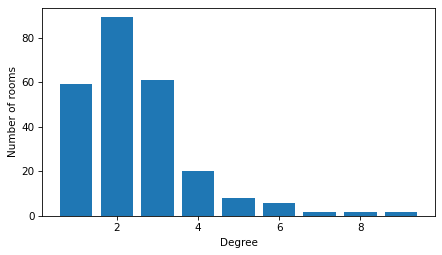

In [ ]:
degrees = [d for n, d in G.degree()]
pmf = pd.Series(degrees).value_counts()
plt.bar(pmf.index, pmf.values)
decorate(xlabel="Degree", ylabel="Number of rooms")

Most rooms are connected to one, two, or three neighbors, but a few rooms are connected to eight or nine.
To visualize the layout, we'll use the NetworkX function `kamada_kawai_layout`, which tries to arrange the nodes so the distance between the nodes is proportional to the length of the path that connects them in the graph.
Some of the "rooms" with high degree are actually hallways or staircases.

In [ ]:
pos = nx.kamada_kawai_layout(G)

The result does not necessarily reflect the actual arrangement of the rooms -- in particular, it does not take into account that rooms may be on different floors.
But it creates a visual representation of the layout of the museum.
Here's what it looks like.

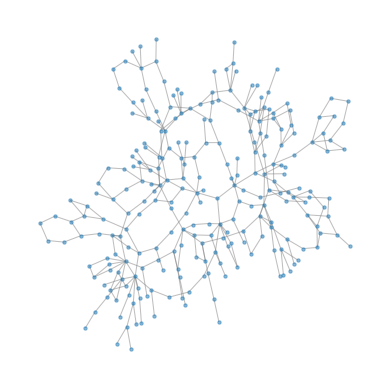

In [ ]:
plt.figure(figsize=(5, 5))
nx.draw(G, pos, node_size=10, edge_color='gray', alpha=0.5)

Now let's see if we can find that cat.

1. Use the graph to compute the adjacency matrix, `A`, and the transition matrix, `M`.

2. Use `run_random_walk` to simulate a random walk in the museum by repeated matrix multiplication.

3. Use `eigs` to compute the eigenvector of the adjacency matrix that corresponds to the largest eigenvalue, and normalize it so the elements sum to 1.

4. Check that the results of the random walk approximate the eigenvector. If you simulate about 1000 steps, the differences should be less than 0.1%.

In [ ]:
# Solution

A = mfa.to_numpy()
M = A / A.sum(axis=0, keepdims=True)
M.shape

(249, 249)

In [ ]:
# Solution

n = len(M)
x0 = np.full(n, 1/n)
x_final = run_random_walk(M, x0, steps=1000)
x_final.shape

(249,)

In [ ]:
# Solution

from scipy.sparse.linalg import eigs

val, vec = eigs(M, k=1)
vec = np.abs(vec[:, 0] / vec.sum())
vec.shape

(249,)

In [ ]:
# Solution

np.allclose(x_final, vec, rtol=1e-4)

True

If `vec` is the eigenvector of the adjacency matrix, you can use the following cell to display the museum graph, using the color and size of the nodes to show their relative probabilities.

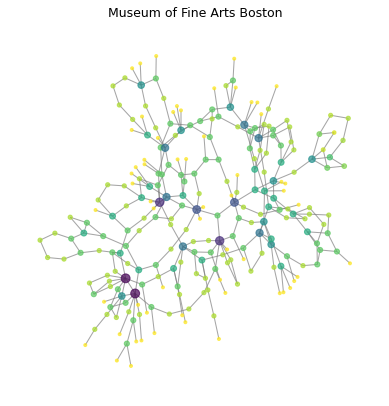

In [ ]:
plt.figure(figsize=(5, 5))
nx.draw(
    G, pos,
    node_size=vec * 5000,
    node_color=vec,
    cmap=plt.cm.viridis_r,
    edge_color='gray',
    alpha=0.7
)
plt.title(f"{museum_name}");

[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)